# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \kappa (\frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}) + S(x,y,t)
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from torch.autograd import Variable

In [2]:
import numpy as np

In [3]:
batch_size = 4096
block_size = 8
batch_size * block_size

32768

In [4]:
# Select a random subset of the coordinates for the mini-batch
x = torch.arange(0, 0.1 + 0.001, 0.001)
num_samples = x.shape[0]
perm = torch.randperm(num_samples)[:batch_size]
minibatch_coords = x[perm]

In [5]:
minibatch_coords

tensor([0.0770, 0.0010, 0.0210, 0.0020, 0.0180, 0.0080, 0.0650, 0.0270, 0.0280,
        0.0720, 0.0540, 0.0410, 0.0000, 0.0480, 0.0240, 0.0620, 0.0440, 0.0980,
        0.0390, 0.0950, 0.0500, 0.0250, 0.0870, 0.0610, 0.0920, 0.0460, 0.0420,
        0.0860, 0.0850, 0.0190, 0.0960, 0.0970, 0.0530, 0.0430, 0.0810, 0.0940,
        0.0290, 0.0340, 0.0120, 0.0310, 0.0880, 0.0130, 0.0630, 0.0170, 0.0150,
        0.0910, 0.0780, 0.0360, 0.0490, 0.0140, 0.0050, 0.0580, 0.0560, 0.0790,
        0.0760, 0.0690, 0.0570, 0.0890, 0.0040, 0.0510, 0.0800, 0.0370, 0.0640,
        0.0900, 0.0400, 0.0550, 0.0320, 0.0110, 0.0670, 0.0220, 0.0060, 0.0090,
        0.0300, 0.0030, 0.0820, 0.0380, 0.0660, 0.0450, 0.0700, 0.0350, 0.0160,
        0.0740, 0.0590, 0.0830, 0.0680, 0.0520, 0.0200, 0.0600, 0.0100, 0.0230,
        0.0750, 0.0710, 0.1000, 0.0330, 0.0930, 0.0840, 0.0990, 0.0260, 0.0070,
        0.0730, 0.0470])

In [6]:
# rewrite in layer, this is rather boilplate code 
class DiffNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(DiffNet, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, X):
        out = self.layers(X)
        return out

In [25]:
class MyDataset(Dataset):
    def __init__(self, coords):
        self.coords = coords
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self,idx):
        return self.coords[idx]
        
    

## New layer architecture (Giulio)


In [7]:
class ComplexHeatEquationNet(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNet, self).__init__()
        self.fc1 = torch.nn.Linear(3, 512)
        self.ln1 = torch.nn.LayerNorm(512)
        self.silu1 = torch.nn.SiLU()
        self.fc2 = torch.nn.Linear(512, 256)
        self.ln2 = torch.nn.LayerNorm(256)
        self.silu2 = torch.nn.SiLU()
        self.fc3 = torch.nn.Linear(256, 128)
        self.ln3 = torch.nn.LayerNorm(128)
        self.silu3 = torch.nn.SiLU()
        self.fc4 = torch.nn.Linear(128, 64)
        self.ln4 = torch.nn.LayerNorm(64)
        self.silu4 = torch.nn.SiLU()
        self.fc5 = torch.nn.Linear(64, 32)
        self.ln5 = torch.nn.LayerNorm(32)
        self.silu5 = torch.nn.SiLU()
        self.fc6 = torch.nn.Linear(32, 1)

    def forward(self, X):
        x = self.silu1(self.ln1(self.fc1(X)))
        x = self.silu2(self.ln2(self.fc2(x)))
        x = self.silu3(self.ln3(self.fc3(x)))
        x = self.silu4(self.ln4(self.fc4(x)))
        x = self.silu5(self.ln5(self.fc5(x)))
        x = self.fc6(x)
        return x

Material properties for this case:

In [9]:
ρ = 7860; Cp = 624; k = 30.1
γ = 2.5e+4; P = 1e+5; r0 = 0.005; y_min=0.0; y_max = 0.1; x_min = 0.0; x_max = 0.1;
κ = k/(ρ * Cp)
T0 = 300.0

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [10]:
learn_rate = 0.01
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        #device = "cpu"
        # build model
        # self.model = DiffNet(
        #        input_size=3,
        #        hidden_size=128,
        #        output_size=1,
        #        depth=5,
        #        act=torch.nn.Tanh).to(device)
        self.model = ComplexHeatEquationNet().to(device)
        # Initial and boundary conditions, we first create the 
        # meshgrid for x and y coordinates. The mesh is regular 
        # grid with h and k steps.
        self.h = 0.002
        self.k = 0.002
        self.dt = 0.002
        
        x = torch.arange(0, 0.1 + self.h, self.h)
        y = torch.arange(0, 0.1 + self.k, self.k)
        t = torch.arange(0, 0.1 + self.dt, self.dt)
        
        
        xmin_bc = torch.stack(torch.meshgrid(x[0],y,t)).reshape(3,-1).T
        xmax_bc = torch.stack(torch.meshgrid(x[-1],y,t)).reshape(3,-1).T
        ymin_bc = torch.stack(torch.meshgrid(x,y[0],t)).reshape(3,-1).T
        ymax_bc = torch.stack(torch.meshgrid(x,y[-1],t)).reshape(3,-1).T
        #print(f"xmin_bc requires grad: {xmin_bc.is_leaf}")
        ic = torch.stack(torch.meshgrid(x,y,t[0])).reshape(3,-1).T
        
        # make training bcs
        # self.bc_train = torch.cat([ic, xmin_bc, xmax_bc, ymin_bc, ymax_bc]) @ivt note this are all boundary conditions
        self.bc_train = torch.cat([ic, xmin_bc, xmax_bc, ymin_bc])
        self.bc_train = self.bc_train.to(device)
        #print(f"bc_train : {self.bc_train.shape}")
        
        self.X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)
        self.X.requires_grad = True
        #print(f"X shape: {self.X.shape}")
        
        self.all_zeros = torch.zeros_like(self.X).to(device)
        self.all_zeros.requires_grad = False
        
        #initial and boundary condition 
        u_init = torch.zeros(len(ic))
        u_xmin = torch.ones(len(xmin_bc))*T0
        u_xmax = torch.ones(len(xmax_bc))*T0
        u_ymin = torch.ones(len(ymax_bc))*T0
        u_ymax = torch.ones(len(ymin_bc))*T0
        
        # self.u_train = torch.cat([u_init, u_xmin, u_xmax, u_ymin, u_ymax])
        self.u_train = torch.cat([u_init, u_xmin, u_xmax, u_ymin])
        self.u_train = self.u_train.unsqueeze(1)
        self.u_train = self.u_train.to(device)
        
        self.mse_cost_function = nn.MSELoss()
        self.optimizer = torch.optim.LBFGS(self.model.parameters(),lr=learn_rate,max_iter=500,max_eval=50000,
                                  history_size=50,tolerance_grad=1e-5,tolerance_change=1.0 * np.finfo(float).eps)
        self.optimizer_Adam = torch.optim.Adam(self.model.parameters())
        self.iter = 0
        
    def source(self): 
        return 2*P/(torch.pi*r0**2)*torch.exp(-2/(r0**2)*((self.X[:,0]-self.X[:,2]*0.02)**2 + (self.X[:,1]-y_max/2)**2))

    def f(self):
        u = self.model(self.X) 
             
        u_dX = torch.autograd.grad(
            u, self.X, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = u_dX[:,0]
        u_y = u_dX[:,1]
        u_t = u_dX[:,2]
        
       
        
        u_dXX = torch.autograd.grad(
            u_dX, self.X, 
            grad_outputs=torch.ones_like(u_dX),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = u_dXX[:,0]
        u_yy = u_dXX[:,1]
        
        return u_t - κ*u_xx - κ*u_yy - 1/(ρ * Cp) * self.source()
    
    def loss_func(self):
        self.optimizer_Adam.zero_grad()
        # initial and boundary conditions
        out = self.model(self.bc_train)
        mse_u = self.mse_cost_function(out, self.u_train)
        
        # fix condition for PDE
        out = self.f()
        mse_f = self.mse_cost_function(out, torch.zeros_like(out))
    
        #loss = mse_u + mse_u_xmax + mse_u_xmin + mse_u_ymax + mse_u_ymin + mse_f
        loss = mse_f + mse_u
        loss.backward()
        
        if self.iter % 100 == 0:
            print(f" Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss
        
    def train(self,epochs):
        for epoch in range(epochs):
            for minibatch in dataloader:
                self.ix = torch.randint(0, self.X.shape[0], (batch_size,))
        
            self.optimizer_Adam.step(self.loss_func)
        #self.optimizer.step(self.loss_func)

In [11]:
net = Net()
net.train(10000)

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


 Iter: 0, loss:67823.4375
 Iter: 100, loss:66092.0625
 Iter: 200, loss:64441.77734375
 Iter: 300, loss:62377.55859375
 Iter: 400, loss:59976.76171875
 Iter: 500, loss:57287.6171875
 Iter: 600, loss:54362.84765625
 Iter: 700, loss:51264.78125
 Iter: 800, loss:48063.09765625
 Iter: 900, loss:44820.21484375
 Iter: 1000, loss:41606.06640625
 Iter: 1100, loss:38477.98828125
 Iter: 1200, loss:35489.00390625
 Iter: 1300, loss:32684.212890625
 Iter: 1400, loss:30100.072265625
 Iter: 1500, loss:27764.111328125
 Iter: 1600, loss:25693.994140625
 Iter: 1700, loss:23897.59375
 Iter: 1800, loss:22373.021484375
 Iter: 1900, loss:21110.515625
 Iter: 2000, loss:20091.4375
 Iter: 2100, loss:19291.361328125
 Iter: 2200, loss:18681.662109375
 Iter: 2300, loss:18231.599609375
 Iter: 2400, loss:17910.408203125
 Iter: 2500, loss:17689.203125
 Iter: 2600, loss:17542.37890625
 Iter: 2700, loss:17448.45703125
 Iter: 2800, loss:17367.17578125
 Iter: 2900, loss:17188.65625
 Iter: 3000, loss:16903.068359375
 Iter

In [19]:
net.train(10000)

 Iter: 10000, loss:8620.623046875
 Iter: 10100, loss:5412.5751953125
 Iter: 10200, loss:5540.25
 Iter: 10300, loss:3883.502197265625
 Iter: 10400, loss:6317.451171875
 Iter: 10500, loss:15428.947265625
 Iter: 10600, loss:6097.78369140625
 Iter: 10700, loss:5280.3857421875
 Iter: 10800, loss:13996.6474609375
 Iter: 10900, loss:4303.84814453125
 Iter: 11000, loss:18689.76953125
 Iter: 11100, loss:16527.484375
 Iter: 11200, loss:16462.96484375
 Iter: 11300, loss:16415.921875
 Iter: 11400, loss:16376.95703125
 Iter: 11500, loss:16343.3037109375
 Iter: 11600, loss:16313.583984375
 Iter: 11700, loss:16286.7578125
 Iter: 11800, loss:16261.8076171875
 Iter: 11900, loss:16237.611328125
 Iter: 12000, loss:16212.8896484375
 Iter: 12100, loss:16186.1787109375
 Iter: 12200, loss:16155.8505859375
 Iter: 12300, loss:16120.1923828125
 Iter: 12400, loss:16077.603515625
 Iter: 12500, loss:16026.3662109375
 Iter: 12600, loss:15963.365234375
 Iter: 12700, loss:15881.5166015625
 Iter: 12800, loss:15763.545

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

shape: (21, 21, 21)


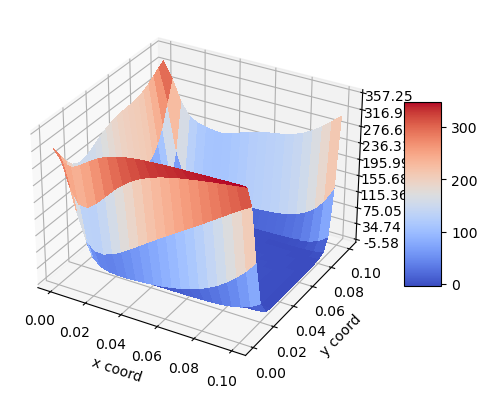

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')
dx = 0.005
x = torch.arange(0,0.1+dx,dx)
y = torch.arange(0,0.1+dx,dx)
t = torch.ones_like(x)*0.6
X = torch.stack(torch.meshgrid(x,y,t)).reshape(3,-1).T.to(device)


u_pred = net.model(X)
um = u_pred.data.cpu().numpy()
um = um.reshape(21,21,21)

x = np.arange(0,0.1+dx,dx)
y = np.arange(0,0.1+dx,dx)
xm, ym = np.meshgrid(x,y)

print(f"shape: {um.shape}")

surf = ax.plot_surface(xm, ym, um[:,:,3], cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel("y coord")
ax.set_xlabel("x coord")
fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [ ]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,2)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)


In [ ]:
mse

In [ ]:
x.shape[0]

In [ ]:
u_pred.shape